## Task 5 — Targeted Adversarial Attack

In this task, we investigate the adversarial robustness of our models.  
We attempt to generate an *imperceptible perturbation* that changes the model’s prediction from a **7 → 3** while keeping pixel changes extremely small.

We compare three models:
1. **Biased Model** — trained on color-correlated dataset
2. **Color-Penalty Model** — trained to reduce color reliance
3. **Consistency Model** — trained using augmentation consistency

Our goal is to measure **how much noise (ε)** is required to fool each model.


In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [2]:
import torch
import random

digit_colors = {
    0: torch.tensor([1.0, 0.2, 0.2]),
    1: torch.tensor([0.2, 1.0, 0.2]),
    2: torch.tensor([0.2, 0.2, 1.0]),
    3: torch.tensor([1.0, 1.0, 0.2]),
    4: torch.tensor([1.0, 0.2, 1.0]),
    5: torch.tensor([0.2, 1.0, 1.0]),
    6: torch.tensor([1.0, 0.5, 0.2]),
    7: torch.tensor([0.6, 0.2, 1.0]),
    8: torch.tensor([0.2, 0.7, 0.7]),
    9: torch.tensor([1.0, 0.4, 0.7]),
}
swapped_colors = {i: digit_colors[(i + 1) % 10] for i in range(10)}
class BiasedTexturedMNIST:
    def __init__(self, bias_prob=0.95,is_hard=False):
        self.bias_prob = bias_prob
        self.is_hard_set = is_hard

    def __call__(self, img, label,rng):
        img = img.squeeze(0)  # [28,28] grayscale
        img = img.clamp(0,1)

        # Digit mask
        digit_mask = img > 0.2
        bg_mask = ~digit_mask
        if self.is_hard_set:
            if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color =  digit_colors[label]
            else:
              base_color = swapped_colors[label]
        else:
          # Choose dominant or random color
          if torch.rand(1, generator=rng).item() < self.bias_prob:
              base_color = digit_colors[label]
          else:
              base_color = torch.rand(3, generator=rng)

        base_color = base_color.view(3,1,1)

        # ---------- FOREGROUND (digit stroke) ----------
        grayscale = img.unsqueeze(0)                 # keep MNIST intensity
        fg_color = base_color * grayscale            # color tied to shape
        fg_texture = torch.randn(3,28,28,generator=rng) * 0.08     # subtle texture
        foreground = foreground = 0.8 * fg_color + 0.2 * grayscale.repeat(3,1,1) + fg_texture


        # ---------- BACKGROUND ----------
        bg_texture = torch.randn(3,28,28,generator=rng) * 0.05     # very subtle noise
        background = base_color * 0.3 + bg_texture  # faint same hue

        # ---------- COMBINE ----------
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [3]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset, bias_prob,is_hard=False):
        self.mnist = mnist_dataset
        self.colorizer = BiasedTexturedMNIST(bias_prob=bias_prob,is_hard=is_hard)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        rng = torch.Generator()
        rng.manual_seed(idx)
        img, label = self.mnist[idx]
        img = self.colorizer(img, label,rng)
        return img, label


In [4]:
from torchvision import datasets, transforms

base_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
base_test  = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_easy = ColoredMNIST(base_train, bias_prob=0.95,is_hard=False)  # strongly biased
test_hard  = ColoredMNIST(base_test,  bias_prob=0.05,is_hard=True)  # mostly wrong colors


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.4MB/s]


In [5]:
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 2,3)
        self.conv2 = nn.Conv2d(16, 24, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(24*2*2, 32)
        self.fc2 = nn.Linear(32, 10)

        self.activations = None  # to store conv features
        self.gradients = None  # for Grad-CAM
    def save_activations(self, x):
        self.activations = x
        return x
    # Hook to save gradients
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.save_activations(x)
        x.register_hook(self.activations_hook)  # hook here
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def get_activations(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        return x  # feature maps BEFORE final pooling


In [39]:
from google.colab import files

def load_model_from_upload(label, device):
    print(f"\nUpload weights for: {label}")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    model = Net().to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    print(f"{label} weights loaded from {filename}")
    return model


### upload weights Task1_v4.pth, Task4.pth, Task4M2.pth in the same order. the weights can be found at github under /Task5/weights

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_biased = load_model_from_upload("Biased Model", device)
model_colorloss = load_model_from_upload("Color-Penalty Model", device)
model_consistency = load_model_from_upload("Consistency/Paper Model", device)



Upload weights for: Biased Model


Saving Task1_v4.pth to Task1_v4 (1).pth
Biased Model weights loaded from Task1_v4 (1).pth

Upload weights for: Color-Penalty Model


Saving Task4.pth to Task4 (2).pth
Color-Penalty Model weights loaded from Task4 (2).pth

Upload weights for: Consistency/Paper Model


Saving Task4M2.pth to Task4M2 (1).pth
Consistency/Paper Model weights loaded from Task4M2 (1).pth


In [42]:
def train(args, model, device, train_loader, optimizer, epoch):
    lambda_color = 0.2
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        optimizer.zero_grad()

        output = model(data)
        ce_loss = F.nll_loss(output, target)


         # Gradient of loss w.r.t. input image
        grads_input = torch.autograd.grad(ce_loss, data, create_graph=True)[0]

        # Measure color sensitivity (differences across channels)
        grads_input = torch.autograd.grad(ce_loss, data, create_graph=True)[0]

        grad_r = grads_input[:, 0, :, :]
        grad_g = grads_input[:, 1, :, :]
        grad_b = grads_input[:, 2, :, :]

        color_penalty = ((grad_r - grad_g).abs().mean() +
                        (grad_g - grad_b).abs().mean() +
                        (grad_b - grad_r).abs().mean())

        color_penalty = color_penalty / (grads_input.abs().mean() + 1e-8)

        loss = ce_loss + lambda_color * color_penalty
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(f"CE: {ce_loss.item():.3f} | Colour loss: {color_penalty.item():.3f}")
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_easy_loader = torch.utils.data.DataLoader(train_easy, batch_size=1000)

test_hard_loader = torch.utils.data.DataLoader(test_hard, batch_size=1000)




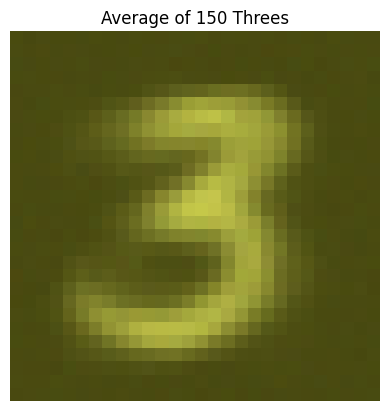

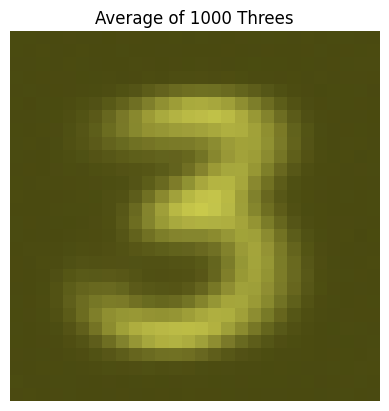

In [45]:
import torch
import matplotlib.pyplot as plt

def compute_average_digit(dataset, digit=3, sample_size=150):
    """
    Compute the average image of a given digit from the dataset.
    """
    images = []
    for img, label in dataset:
        if label == digit:
            images.append(img)
        if len(images) == sample_size:
            break
    if len(images) < sample_size:
        print(f"Only found {len(images)} samples of digit {digit}")
    stack = torch.stack(images)
    return stack.mean(dim=0)  # shape: [C, H, W]

# Compute both averages
avg_150 = compute_average_digit(train_easy, digit=3, sample_size=150)
avg_1000 = compute_average_digit(train_easy, digit=3, sample_size=1000)

# Visualize
def show_image(tensor_img, title=""):
    img = tensor_img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_image(avg_150, title="Average of 150 Threes")
show_image(avg_1000, title="Average of 1000 Threes")


In [21]:
import matplotlib.pyplot as plt
import torch

def show_1000_sevens(dataset, start_idx=0, per_page=100, digit=7):
    """
    Show 100 images per page of digit `digit`, starting from start_idx.
    Use left/right arrows or change start_idx manually to view more.
    """
    images = [img for img, label in dataset if label == digit]

    if len(images) < start_idx + per_page:
        print(f"Only {len(images)} images of digit {digit} available.")
        return

    batch = images[start_idx:start_idx + per_page]
    rows = cols = int(per_page**0.5)
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

    for ax, img in zip(axes.flatten(), batch):
        if img.shape[0] == 1:
            ax.imshow(img.squeeze(), cmap='gray')
        else:
            ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
        ax.axis('off')

    plt.suptitle(f"Digit {digit} samples {start_idx + 1} to {start_idx + per_page}")
    plt.tight_layout()
    plt.show()


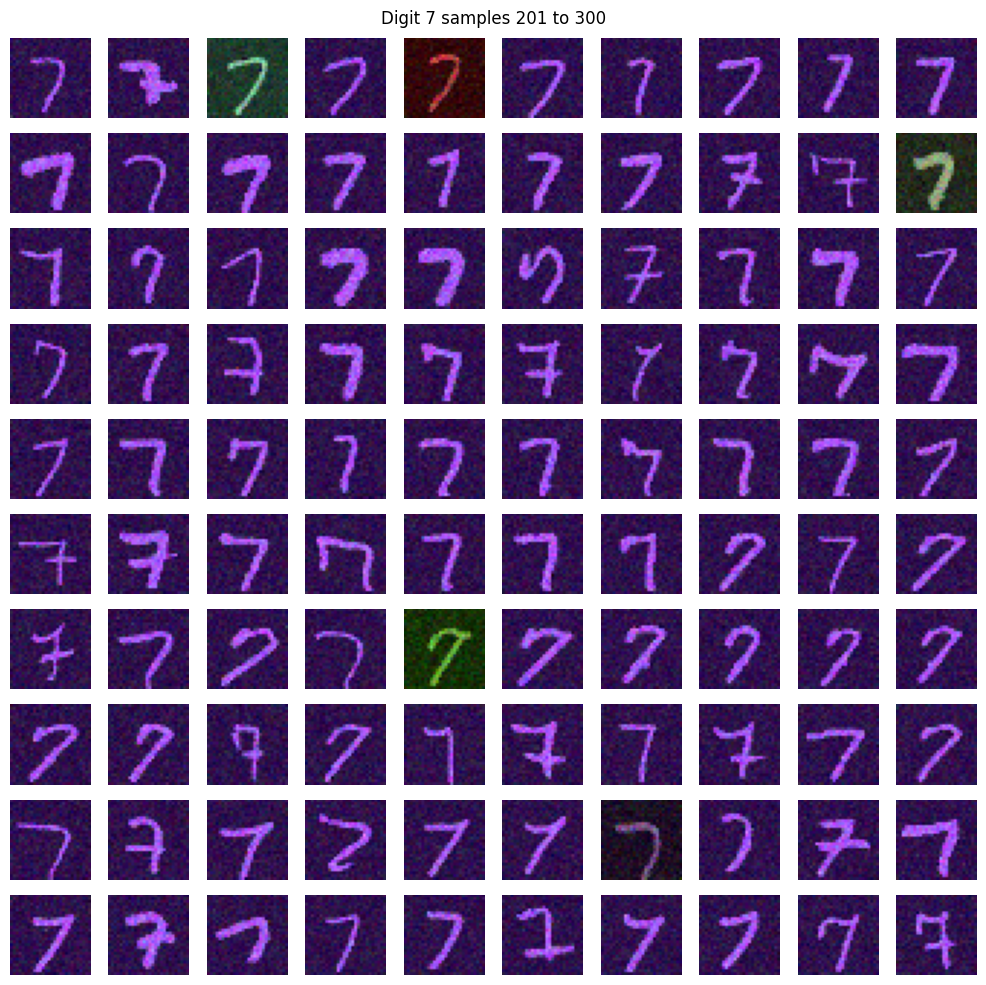

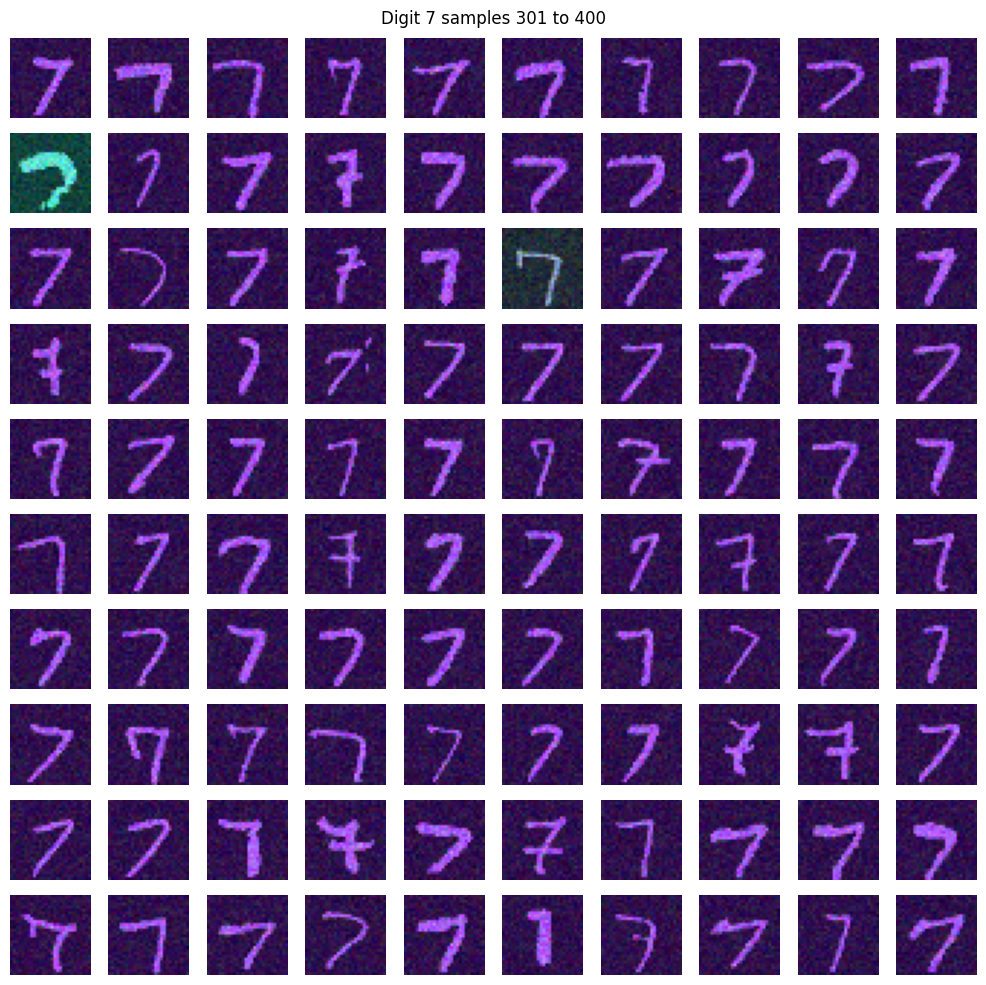

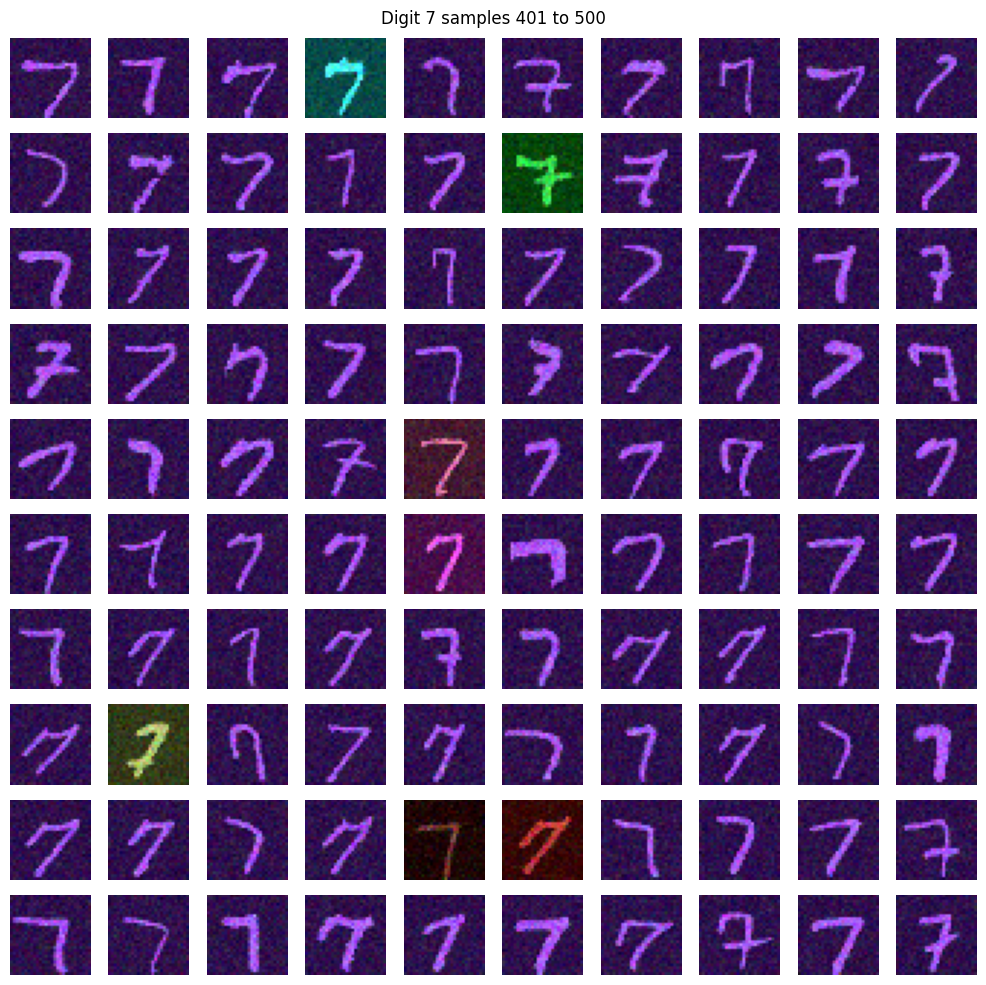

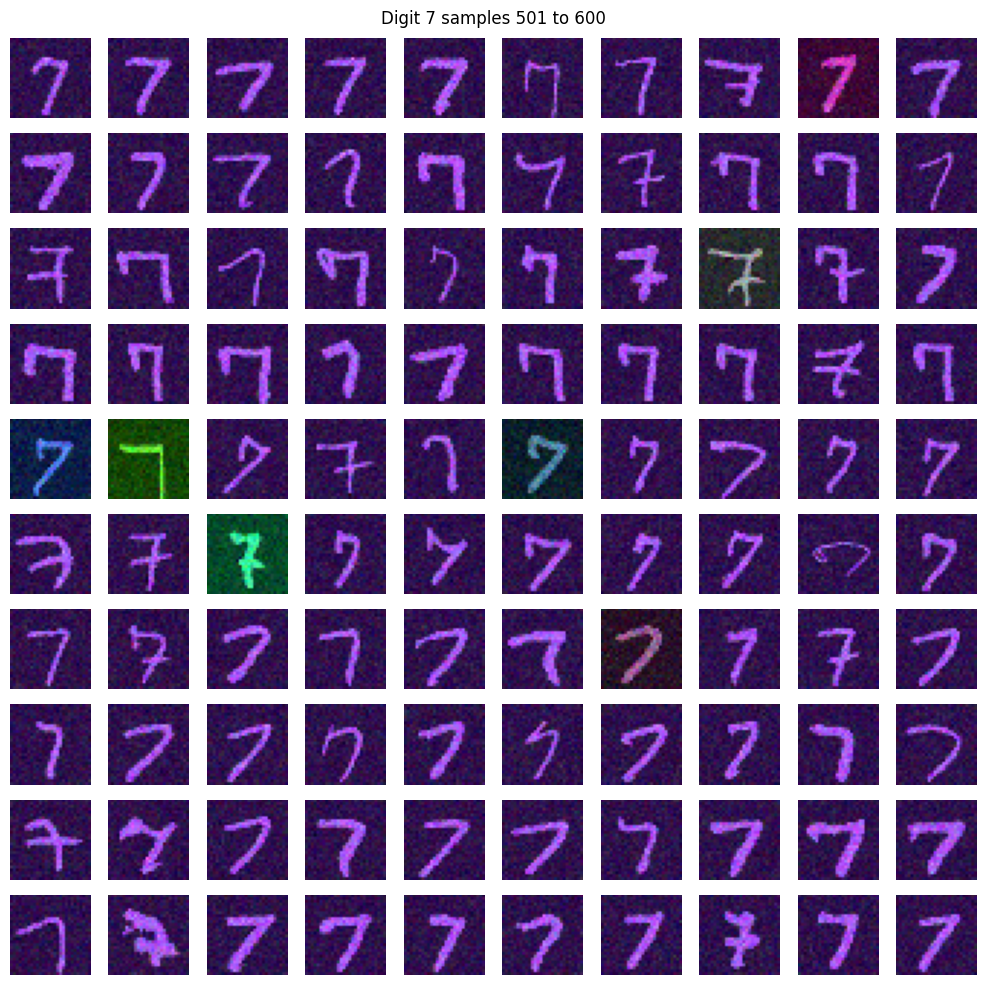

In [49]:
show_1000_sevens(train_easy, start_idx=200)      # Shows 0–99
show_1000_sevens(train_easy, start_idx=300)    # Shows 100–199
# ... up to 900
show_1000_sevens(train_easy, start_idx=400)      # Shows 0–99
show_1000_sevens(train_easy, start_idx=500)


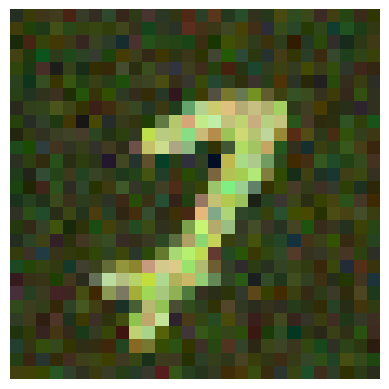

In [94]:
def get_nth_digit(dataset, digit, n=10):
    count = 0
    for img, label in dataset:
        if label == digit:
            count += 1
            if count == n:
                return img, label
    raise ValueError(f"Only found {count} samples of digit {digit}")

# Get the 10th yellowish 7
img_7, label_7 = get_nth_digit(train_easy, digit=7, n=472)

# Visualize it
plt.imshow(img_7.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()


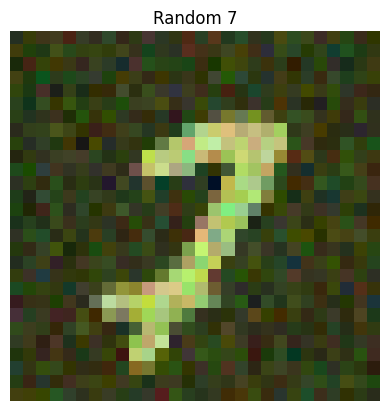

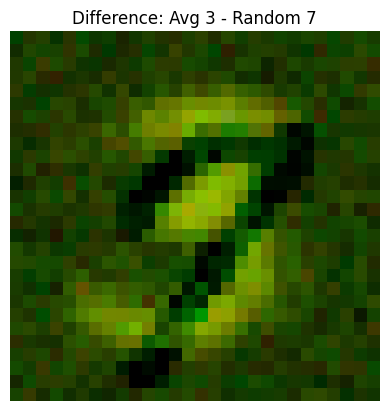

In [95]:
diff = avg_150 - img_7  # or use avg_1000

# Optional: Visualize
show_image(img_7, title="Random 7")
show_image(difference, title="Difference: Avg 3 - Random 7")

In [87]:
epsilon = 0.29
perturbed_img = img_7 + epsilon * diff
perturbed_img = perturbed_img.clamp(0, 1)  # Ensure valid pixel values


In [98]:
epsilon = 0.08

# Step 1: Raw additive perturbation
raw_perturbed = img_7 + epsilon * diff

# Step 2: Clamp the difference to ensure each pixel changes by ≤ ε
# (This ensures that every individual pixel value is only changed slightly)
perturbation = (raw_perturbed - img_7).clamp(-epsilon, +epsilon)

# Step 3: Add bounded perturbation and clamp to [0,1] to ensure valid image
perturbed_img = (img_7 + perturbation).clamp(0, 1)


In [99]:
model.eval()

output = model(perturbed_img.unsqueeze(0).to(device))
probs = F.softmax(output, dim=1).squeeze()

# Print top predictions
for i, p in enumerate(probs):
    print(f"Class {i}: {p.item():.4f}")

print(f"\nPredicted: {probs.argmax().item()}, Confidence: {probs.max().item():.4f}")


Class 0: 0.0001
Class 1: 0.0024
Class 2: 0.0010
Class 3: 0.8741
Class 4: 0.0000
Class 5: 0.0001
Class 6: 0.0000
Class 7: 0.0853
Class 8: 0.0001
Class 9: 0.0370

Predicted: 3, Confidence: 0.8741


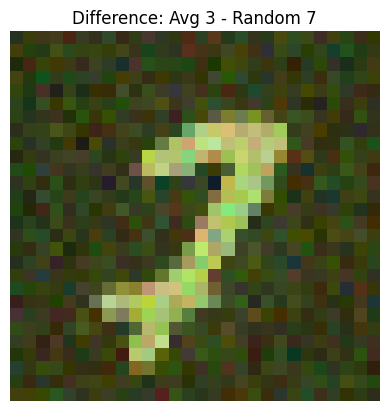

In [100]:
show_image(perturbed_img, title="Difference: Avg 3 - Random 7")

### Targeted PGD Attack

We implement a **targeted Projected Gradient Descent (PGD)** attack.

Unlike FGSM (single-step), this method:
- Iteratively optimizes a learnable noise tensor
- Constrains the noise to remain within an L∞ bound (ε)
- Maximizes the probability of a specific target class (3)

This simulates a worst-case adversarial perturbation under strict visual constraints.


In [116]:
import torch
import torch.nn.functional as F

def targeted_attack(model, original_img, target_class=3, epsilon=0.05, alpha=0.01, steps=100, device="cpu"):
    model.eval()
    original_img = original_img.to(device)

    perturbation = torch.nn.Parameter(torch.zeros_like(original_img))
    optimizer = torch.optim.SGD([perturbation], lr=alpha)

    for step in range(steps):
        optimizer.zero_grad()

        adv_img = original_img + perturbation
        adv_img = torch.clamp(adv_img, original_img - epsilon, original_img + epsilon)
        adv_img = torch.clamp(adv_img, 0, 1)

        output = model(adv_img.unsqueeze(0))
        probs = F.softmax(output, dim=1)

        target_score = probs[0, target_class]
        loss = -torch.log(target_score + 1e-8)

        loss.backward()
        optimizer.step()
        with torch.no_grad():
          perturbation.data = torch.clamp(perturbation.data, -epsilon, epsilon)
        if (step%10000==0):
          print(f"Step {step+1}: Target class confidence = {target_score.item():.4f}")

        if target_score.item() > 0.9:
            print(f"Step {step+1}: Target class confidence = {target_score.item():.4f}")
            print("Attack successful!")
            break

    final_img = torch.clamp(original_img + perturbation, 0, 1).detach()


    perturb_used = (final_img - original_img).abs()
    epsilon_used = perturb_used.max().item()
    print(f"Max pixel change (epsilon used): {epsilon_used:.5f}")

    import matplotlib.pyplot as plt

    original_np = original_img.detach().cpu().squeeze().permute(1,2,0).numpy()
    perturb_np = perturb_used.cpu().squeeze().permute(1,2,0).numpy()
    final_np = final_img.cpu().squeeze().permute(1,2,0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(perturb_np / epsilon, cmap='inferno')
    axes[1].set_title("Perturbation (|Δ|)")
    axes[1].axis("off")

    axes[2].imshow(final_np)
    axes[2].set_title("Adversarial Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    return final_img, epsilon_used



### Visualizing the Adversarial Perturbation

Below we visualize:
- The original image
- The perturbation magnitude
- The final adversarial image

Although the noise is nearly invisible to humans, it significantly alters the model’s decision — highlighting the vulnerability of neural networks to carefully structured perturbations.



===== Attacking Biased =====
Step 1: Target class confidence = 0.3286
Step 10001: Target class confidence = 0.7735
Step 20001: Target class confidence = 0.7744
Step 30001: Target class confidence = 0.7746
Step 40001: Target class confidence = 0.7748
Step 50001: Target class confidence = 0.8592
Step 60001: Target class confidence = 0.8597
Step 70001: Target class confidence = 0.8598
Step 80001: Target class confidence = 0.8598
Step 90001: Target class confidence = 0.8599


Max pixel change (epsilon used): 0.05000


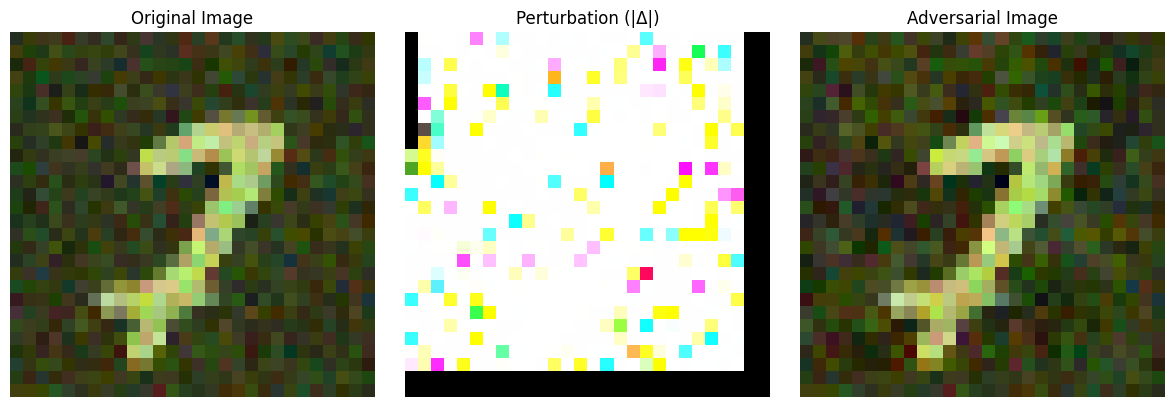


===== Attacking ColorLoss =====
Step 1: Target class confidence = 0.1866
Step 4: Target class confidence = 0.9272
Attack successful!
Max pixel change (epsilon used): 0.02958


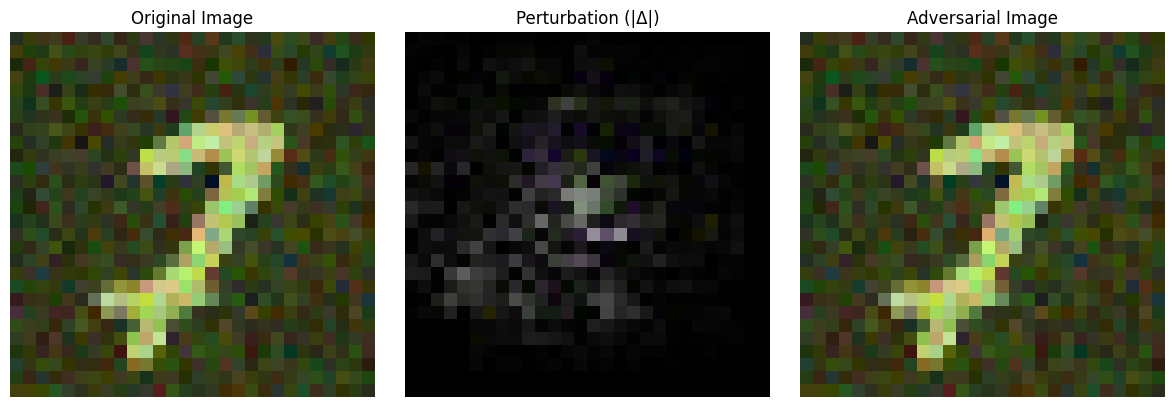


===== Attacking Consistency =====
Step 1: Target class confidence = 0.1101
Step 10001: Target class confidence = 0.4177
Step 20001: Target class confidence = 0.4182
Step 30001: Target class confidence = 0.4184
Step 40001: Target class confidence = 0.4185
Step 50001: Target class confidence = 0.4184
Step 60001: Target class confidence = 0.4185
Step 70001: Target class confidence = 0.4185
Step 80001: Target class confidence = 0.4185
Step 90001: Target class confidence = 0.4185


Max pixel change (epsilon used): 0.05000


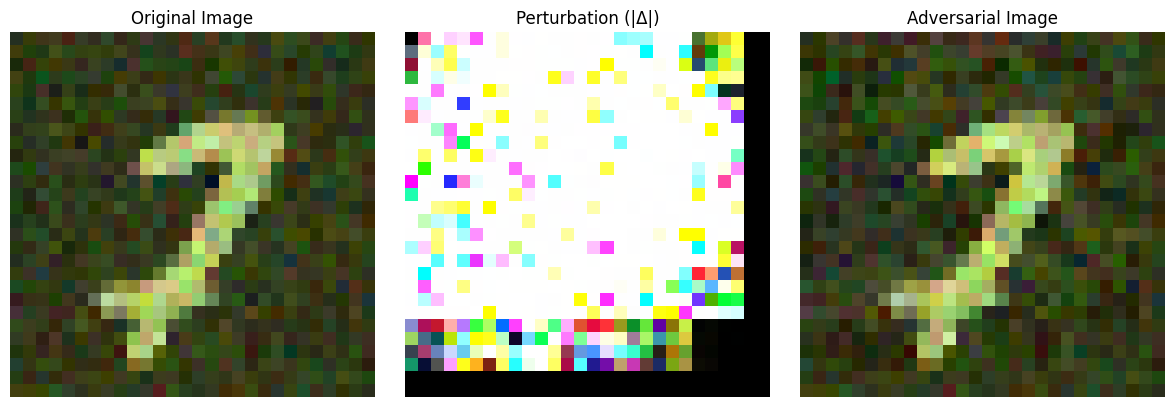

In [117]:
def run_attack_on_models(models_dict, img, target_class=3, epsilon=0.05):
    results = {}

    for name, model in models_dict.items():
        print(f"\n===== Attacking {name} =====")
        adv_img, eps_used = targeted_attack(
            model,
            img,
            target_class=target_class,
            epsilon=epsilon,
            alpha=0.01,
            steps=100000,
            device=device
        )
        results[name] = {
            "adv_img": adv_img,
            "epsilon_used": eps_used
        }

    return results


models = {
    "Biased": model_biased,
    "ColorLoss": model_colorloss,
    "Consistency": model_consistency
}

attack_results = run_attack_on_models(models, img_7, target_class=3)


## The colourloss model was way easier to fool than the biased model and the augmented consistency model was the hardest

## Final pertubtion probabilties

In [69]:
model_biased.eval()

output = model_biased(perturbed[0].unsqueeze(0).to(device))
probs = F.softmax(output, dim=1).squeeze()

# Print top predictions
for i, p in enumerate(probs):
    print(f"Class {i}: {p.item():.4f}")

print(f"\nPredicted: {probs.argmax().item()}, Confidence: {probs.max().item():.4f}")

Class 0: 0.0410
Class 1: 0.1293
Class 2: 0.1088
Class 3: 0.3206
Class 4: 0.0258
Class 5: 0.0334
Class 6: 0.0186
Class 7: 0.1545
Class 8: 0.0712
Class 9: 0.0967

Predicted: 3, Confidence: 0.3206


In [71]:
model_colorloss.eval()

output = model_colorloss(perturbed[0].unsqueeze(0).to(device))
probs = F.softmax(output, dim=1).squeeze()

# Print top predictions
for i, p in enumerate(probs):
    print(f"Class {i}: {p.item():.4f}")

print(f"\nPredicted: {probs.argmax().item()}, Confidence: {probs.max().item():.4f}")

Class 0: 0.0000
Class 1: 0.0006
Class 2: 0.0003
Class 3: 0.9425
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0436
Class 8: 0.0000
Class 9: 0.0130

Predicted: 3, Confidence: 0.9425


In [72]:
model_consistency.eval()

output = model_consistency(perturbed[0].unsqueeze(0).to(device))
probs = F.softmax(output, dim=1).squeeze()

# Print top predictions
for i, p in enumerate(probs):
    print(f"Class {i}: {p.item():.4f}")

print(f"\nPredicted: {probs.argmax().item()}, Confidence: {probs.max().item():.4f}")

Class 0: 0.0915
Class 1: 0.0752
Class 2: 0.1113
Class 3: 0.1191
Class 4: 0.0726
Class 5: 0.0768
Class 6: 0.0706
Class 7: 0.2159
Class 8: 0.0765
Class 9: 0.0906

Predicted: 7, Confidence: 0.2159
